# Calibration of ML models

Calibrations of ML models is the set of the methods for good and right evaluation of the probabilities of predictions. It's needed in problems where our decision substantially depends on probabilities.

For instance:
* Can we as a bank give a credit to a borrower (it depends on probability of the bankruptcy of the borrower)?
* Should we accept a customer's ask about insurance (It depends on probability of occurrence of an insured event)?
* If $f(x)$ is margin which we'll obtain in case of buying of the product by a customer, and $p(x)$ is a probability of buying of the product in case of we call the customer, then $\widetilde{f}(x)$ is calibrated probability $p(x)$. In this case we should call firstly the customers who have the maximal value of $\widetilde{f}(x)$.

Besides, probabilities may be useful for model interpretation and complex quality evaluation with incresed confidence. And finally, in more difficult pipelines probabilities can have direct influence on algorithms using the model's output.

In ML model calibration two directions may be highlighted:

## Evaluation of calibration degree of the given model

In [1]:
import warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib inline

### Training of the initial models

We'll consider calibration on an example of the problem of credit scoring (binary classification: 1 - we'll give credit to a customer, 0 - we won't).

In [2]:
dataset = pd.read_csv("german_credit.csv")
dataset.head(3)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,no checking account,18,all credits at this bank paid back duly,car (used),1049,unknown/no savings account,< 1 yr,< 20,female : non-single or male : single,none,...,car or other,21,none,for free,1,skilled employee/official,0 to 2,no,no,good
1,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,male : married/widowed,none,...,unknown / no property,36,none,for free,2-3,skilled employee/official,3 or more,no,no,good
2,... < 0 DM,12,no credits taken/all credits paid back duly,retraining,841,... < 100 DM,4 <= ... < 7 yrs,25 <= ... < 35,female : non-single or male : single,none,...,unknown / no property,23,none,for free,1,unskilled - resident,0 to 2,no,no,good


In [3]:
for x in dataset.columns:
    if dataset[x].dtype == "object":
        dataset[x] = LabelEncoder().fit_transform(dataset[x])

dataset['age'] = pd.cut(
    dataset.age, 
    (18, 25, 35, 50, 65, 80),
    labels=[0, 1, 2, 3, 4]
)

dataset['amount'] = pd.cut(
    dataset.amount, 
    (250, 1000, 2000, 4000, 8000, 20000),
    labels=[0, 1, 2, 3, 4]
)

dataset['duration'] = pd.cut(
    dataset.duration, 
    (4, 6, 8, 12, 18, 24, 36, 48, 72),
    labels=[0, 1, 2, 3, 4, 5, 6, 7]
)

dataset.head(3)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,3,3,0,2,1,4,2,2,0,2,...,1,0,1,0,0,1,0,0,0,1
1,3,2,0,5,2,4,0,1,3,2,...,3,2,1,0,1,1,1,0,0,1
2,0,2,4,8,0,0,1,1,0,2,...,3,0,1,0,0,3,0,0,0,1


In [4]:
X = dataset.drop(['credit_risk'],  axis=1)
y = dataset['credit_risk']

In [5]:
X.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,3,3,0,2,1,4,2,2,0,2,3,1,0,1,0,0,1,0,0,0
1,3,2,0,5,2,4,0,1,3,2,0,3,2,1,0,1,1,1,0,0
2,0,2,4,8,0,0,1,1,0,2,3,3,0,1,0,0,3,0,0,0
3,3,2,0,5,2,4,0,0,3,2,0,3,2,1,0,1,3,1,0,1
4,3,2,0,5,2,4,0,2,3,2,3,1,2,0,2,1,3,0,0,1


Features selection

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# these methods are provide evaluation of importance of the features

In [7]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, y)

rate = pd.DataFrame(fs.scores_, X.columns, columns=['score'])
rate = rate.sort_values('score', axis=0)
rate

,score
people_liable,0.009071
employment_duration,0.079635
installment_rate,0.126847
present_residence,0.155848
amount,0.428326
other_debtors,0.807899
job,1.071934
telephone,1.328891
number_credits,2.091652
duration,2.588473


In [8]:
cols = rate.index.values[::-1]
features = X[[col for col in cols[:len(cols) // 2]]]

In our data there are imbalance of classes and it would be nice to fix it. There are different ways to do it. One of them - to synthesize objects of less represented class.

The most popular algorithm for it - <u>SMOTE (Syntetic Minority Over-sampling Technique)</u>.

In [9]:
!pip install imbalanced-learn

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [11]:
X_smote, y_smote = smote.fit_resample(features.values, y.values)
print(f"Before SMOTE: {y.value_counts()}\n")
print(f"After SMOTE: {np.unique(y_smote, return_counts=True)}")

Before SMOTE: credit_risk
1    700
0    300
Name: count, dtype: int64

After SMOTE: (array([0, 1]), array([700, 700], dtype=int64))


In [12]:
print("X_smote shape: ", X_smote.shape)
print("y_smote shape: ", y_smote.shape)

X_smote shape:  (1400, 10)
y_smote shape:  (1400,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=7
)

#### Logistic Regression

In [14]:
lr = LogisticRegression(solver="liblinear")
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
lr_y_pred_proba = lr.predict_proba(X_test)[:, 1]

In [15]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       136
           1       0.65      0.59      0.62       144

    accuracy                           0.63       280
   macro avg       0.63      0.63      0.63       280
weighted avg       0.63      0.63      0.63       280



#### RBF SVM

In [16]:
svm_rbf = SVC(kernel="rbf", probability=True)
svm_rbf.fit(X_train, y_train)
svm_rbf_y_pred = svm_rbf.predict(X_test)
svm_rbf_y_pred_proba = svm_rbf.predict_proba(X_test)[:, 1]

In [17]:
print(classification_report(y_test, svm_rbf_y_pred))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       136
           1       0.71      0.62      0.66       144

    accuracy                           0.68       280
   macro avg       0.68      0.68      0.67       280
weighted avg       0.68      0.68      0.67       280



#### Polynomial SVM

In [18]:
svm_poly = SVC(kernel="poly", degree=8, probability=True)
svm_poly.fit(X_train, y_train)
svm_poly_y_pred = svm_poly.predict(X_test)
svm_poly_y_pred_proba = svm_poly.predict_proba(X_test)[:, 1]

In [19]:
print(classification_report(y_test, svm_poly_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       136
           1       0.80      0.80      0.80       144

    accuracy                           0.80       280
   macro avg       0.80      0.80      0.80       280
weighted avg       0.80      0.80      0.80       280



#### kNN

In [20]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
knn_y_pred_proba = knn.predict_proba(X_test)[:, 1]

In [21]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       136
           1       0.81      0.69      0.75       144

    accuracy                           0.76       280
   macro avg       0.77      0.76      0.76       280
weighted avg       0.77      0.76      0.76       280



### Evaluation

<u><b>Definition</b></u>: Predictions considered as calibrated if predicted probability of occurrence of the event is X% and the real frequency of occurrence of the event is X%, too.

For example, we had predicted about 2/3 customers as customers whom shouldn't be given by a credit, and after checking the full set of the real customers we found out that number of customers whom shouldn't be given by a credit are about 2/3, indeed. Thus, we can considered as calibrated the model which made the predictions.

#### Evaluation with metrics

There are several metrics which can explain us how good our model calibrated are.

As an "example model" let's consider SVM with polynomial kernel.

In [22]:
y_pred_proba = svm_poly_y_pred_proba

##### Log loss

* `log_loss` is a chrestomathy metric for measurements of how well the predicted probabilities corresponds the reality.
* For example, `ROC-AUC` can measure quality of <b>ranging</b> (how good the marks of predicted classes are sorted if we sort the results of predictions by its probabilities) but tell us nothing about <b>calibration</b> quality itself.
* `log_loss` gives us more balanced view both about ability of the model to build separating surface and about quality of its calibration.
* The values of the `log_loss` itself are hardly interpreted, so it usually used in comparisons:
  $$log \; loss = -\dfrac{1}{n}\left( \sum [y_i = 1]\ln(p_i) + \sum [y_i = -1]\ln(1 - p_i) \right)$$

<u><b>Examples</b></u>:
* If the predicted event's probability is 0.25 and it's happened, $log \; loss = -\ln(0.25) = \ln(4)$
* If the predicted event's probability is 0.8 and it's didn't happen, $log \; loss = -\ln(1 - 0.8) = \ln(5)$
* log loss equals to zero if we have $p_i = 1$ and the event happened.
* log loss $\rightarrow \infty$ if we have $p_i = 1$ and the event didn't happen.

In [23]:
from sklearn.metrics import roc_auc_score, log_loss

roc_auc_score(y_test, y_pred_proba), log_loss(y_test, y_pred_proba)

(0.8135978349673203, 0.6178658499928158)

Dividing of all the probabilities by the positive number doesn't change its `roc-auc` metric because it's doesn't divide the ranging of probabilities.

But it changes `log loss`.

In [24]:
roc_auc_score(y_test, y_pred_proba / 4), log_loss(y_test, y_pred_proba / 4)

(0.8135978349673203, 1.0778207923372907)

##### Brief Score

$$\text{Brief Score} = \dfrac{1}{n}\sum_{i=1}^{n}(y_i - p_i)^2$$

As you can see from the formula, `Brief Score` in the different name for MSE between predicted probabilities and marks of the classes (0 or 1). For example, if predicted probability is 0.7 and mark of the class is 1, then error on the object is $(1 - 0.7)^2 = 0.09$. If we'll take the average by all the objects we'll give `Brief Score` metric for the model.

Note, that `Brief Score` is limited above by unit (1 is the worst case), in the same time `log loss` can take infinitely big values.

In [25]:
from sklearn.metrics import brier_score_loss

brier_score_loss(y_test, y_pred_proba)

0.21254596457421573

#### Evaluation with calibration diagram

Source: Yandex's School of Data Analysis online textbook ("ШАД Яндекса, Как оценивать вероятности")

Let's formulate once again what does it means we predict correct probability of class 1 (let's denote it through $q(x_i)$): it means the prediction like "an object of class $x_i$ belongs to class 1 with probability $\dfrac{2}{3}$" must be correct in $\dfrac{2}{3}$ cases. In another words, if we take all the objects for whom the predicted probability is $\dfrac{2}{3}$ then among them about $\dfrac{2}{3}$ of objects really belong to class 1. Mathematically speaking 
$$\text{"} \; \text{Our model gives us a correct prediction of class 1 in case if} \; \hat{p} \; \text{- is predicted probability of class 1 and then} \; P(y_i = 1 | q(x_i) = \hat{p}) = \hat{p} \text{\:"}$$

In real life $\hat{p}$ it's rather real numbers different for different $y_i$ and no common probabilities fof all the objects will be calculated. But we can to divide the interval $[0; 1]$ into bins and in the bins calculate 
proportion of objects belonging to the class 1 there, and then compare this proportion to average probability in the bin.s

<center><img src="calibration_diagram.png"></center>

Explanation:
* By hirizontal we have probabilities values $p$
* By vertical we have percent of objects belonging to the class 1, transformed into interval $[0, 1]$

A model which predicts probabilities perfectly has yellow points on the diagram on the same positions as pink ones.

But on the graph above we can see that it isn't. It means our model 
systematically overstate predicted probability (pink points) and threshold should be shifted to the right, too.s

<center><img src="calibration_diagram_1.png"></center>

But such an illustration usually tells about serious issue with the classificatior (underfitting or very bad or incorrect data, for example). Nore often we can find two following situations:

1. <u>Overconfident classificator</u>
<center><img src="calibration_diagram_2.png"></center>

Such a situation usually may occure with strong classicators (neural networks, for instance) which were trained to predict the marks of the classes, not probabilities, therefore the training process was stimulating it always to give an answer as near to 1 or 0 as possible.

2. <u>Underconfident classificator</u>
<center><img src="calibration_diagram_3.png"></center>

Such situation can occure when we pay too much attention to hard to classification objects on border of the classes (for instance it may be possible in SVM), in a manner to the prejudice of more uniquely defined points.

We also can build a histogram with probabilities and with number of objects with such probabilities. Let's consider it on example of overfitted and weak classifiers:

<center><img src="calibration_diagram_4.png"></center>

Predictions of the weak classifier tends to middle part of x-axis (i.e. to probability equals to 0.5 - this is unconfident with always unconfident predictions). In contrary, predictions of the overfitted classifier nearly always laid in area of probability equals to 0 and 1 (very confident but often wrong predictions).

##### sklearn calibration_curve

Let's see on the implementation of calibraion curve builder in `sklearn`.

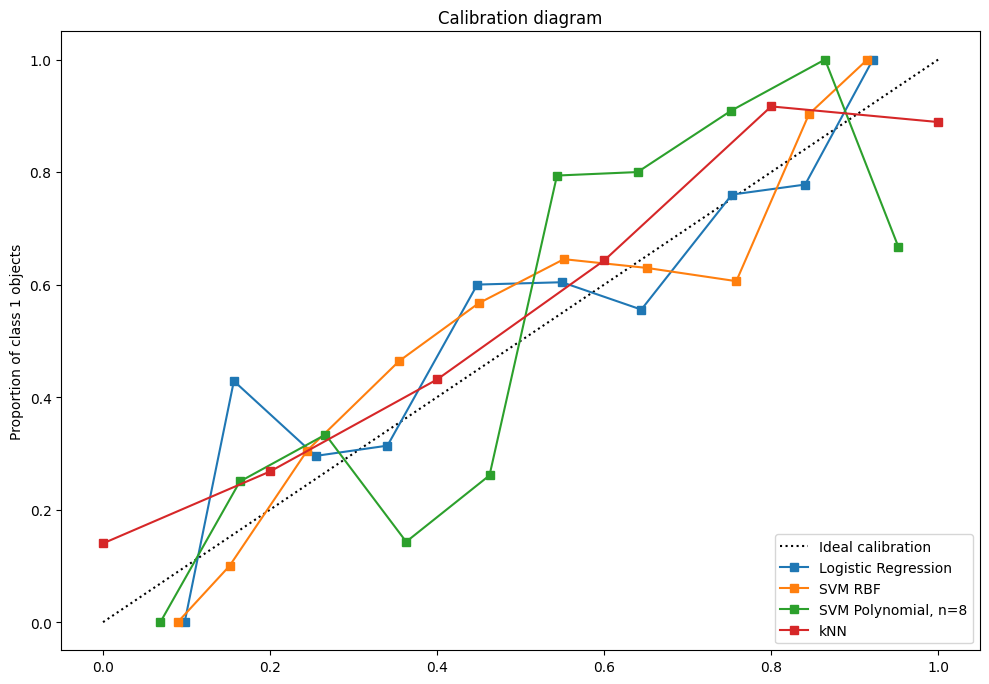

In [26]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
axl = plt.subplot2grid((3,1), (0, 0), rowspan=2)
axl.plot([0, 1], [0, 1], "k:", label='Ideal calibration')

for clf, name in [(lr, "Logistic Regression"),
                  (svm_rbf, "SVM RBF"),
                  (svm_poly, "SVM Polynomial, n=8"),
                  (knn, 'kNN')]:
    clf.fit(X_train, y_train)
    prob_pos = clf.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_pos, n_bins=10
    )
    axl.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name, ))

axl.set_ylabel("Proportion of class 1 objects")
axl.set_ylim([-0.05, 1.05])
axl.legend(loc="lower right")
axl.set_title("Calibration diagram")
plt.tight_layout()
plt.show()

##### ml-insights calibration_curve

You can avoid all these huge bunch of code by using `ml-insights` library.

In [27]:
!pip install ml_insights

In [28]:
import ml_insights as mli

In [29]:
# method documentation

mli.plot_reliability_diagram?

Signature:
mli.plot_reliability_diagram(
    y,
    x,
    bins=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
    show_baseline=True,
    baseline_color='black',
    baseline_width=1,
    error_bars=True,
    error_bar_color='C0',
    error_bar_alpha=0.05,
    error_bar_width=2,
    ci_ref='axis',
    marker='.',
    marker_color='C1',
    marker_edge_color='C1',
    marker_size=50,
    scaling='none',
    scaling_eps=0.0001,
    scaling_base=10,
    cap_width=1,
    cap_size=5,
    show_histogram=False,
    bin_color='C0',
    bin_edge_color='black',
    ax1_x_title='Predicted',
    ax1_y_title='Empirical',
    ax2_x_title='Predicted Scores',
    ax2_y_title='Count',
    ax_title_weight='normal',
    ax_title_size=12,
    title_size=16,
    title_weight='normal',
    reliability_title='Reliability Diagram',
    histogram_title='Probability Distribution',
    layout_pad=3.0,
    legend_names

Standard diagram:

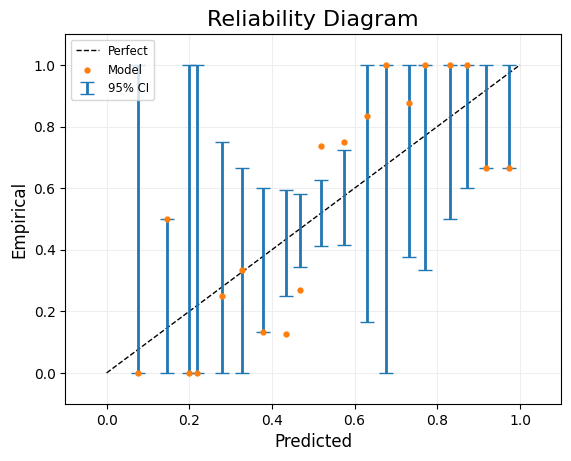

In [30]:
rd = mli.plot_reliability_diagram(y_test, y_pred_proba);
# rd - reliability diagram

These blue sticks repeat the trajectory of our calibration curve from graph above. y_pred_proba here is polynomial SVM.

Now add a histogram:

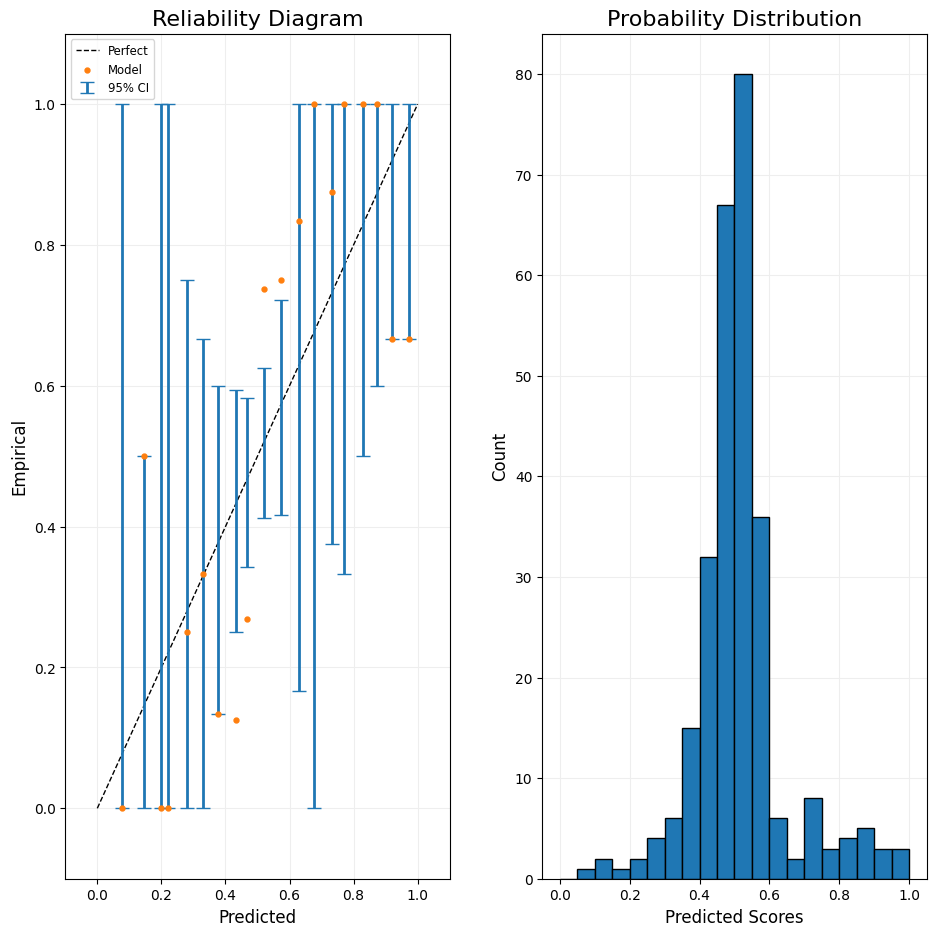

In [31]:
plt.figure(figsize=(10, 10))
mli.plot_reliability_diagram(y_test, y_pred_proba, show_histogram=True);

Now let's pretend that we want to make the bins in which lay many objects smaller, and in controversy make sparse ones bigger.

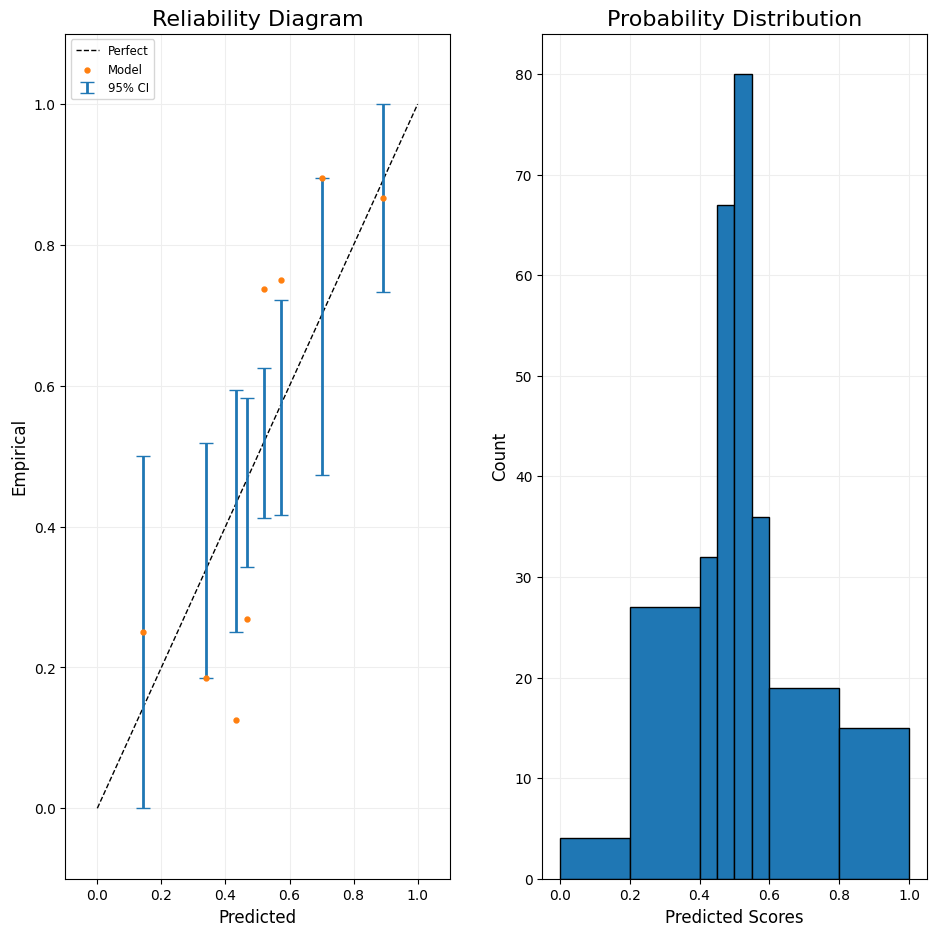

In [32]:
plt.figure(figsize=(10, 10))
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])

mli.plot_reliability_diagram(
    y_test,
    y_pred_proba,
    bins=custom_bins,
    show_histogram=True
);

Probably, our classificator acting strange in area of zero, but from such a representation unambiguous conclusion can't be made. To take a look extremal values nearer we can use logarithmic scale.

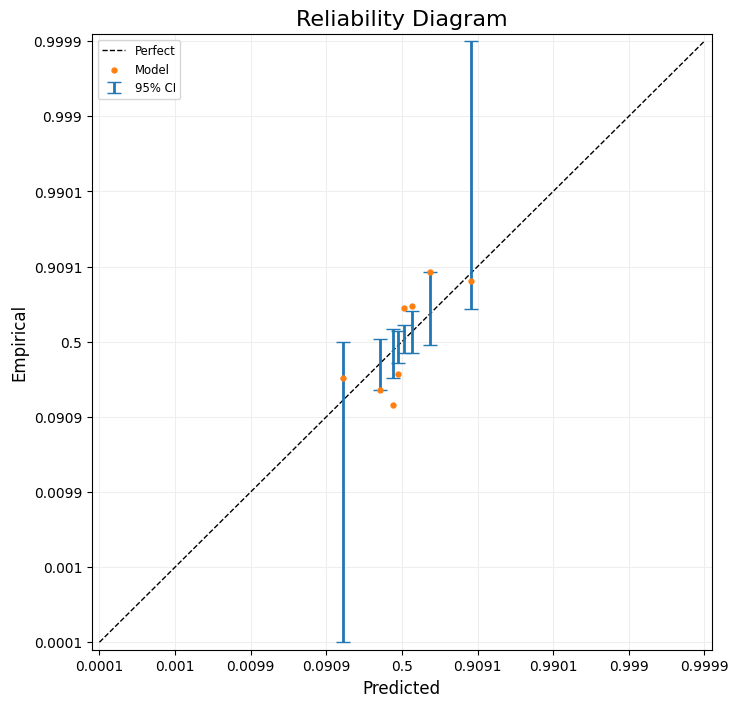

In [33]:
plt.figure(figsize=(8, 8))
rd = mli.plot_reliability_diagram(y_test, y_pred_proba, scaling="logit", bins=custom_bins, marker=".");

The function returned us the `rd` dictionary.

In [34]:
rd.keys()

dict_keys(['pred_probs', 'emp_probs', 'bin_counts'])

In [35]:
rd['pred_probs'], rd['emp_probs'], rd['bin_counts']

(array([0.14241625, 0.34075066, 0.4333861 , 0.46881461, 0.51893011,
        0.57421597, 0.6999066 , 0.89088648]),
 array([0.25      , 0.18518519, 0.125     , 0.26865672, 0.7375    ,
        0.75      , 0.89473684, 0.86666667]),
 array([ 4., 27., 32., 67., 80., 36., 19., 15.]))

## Calibration

Before we talked about evaluation of calibration, and now let's talk about building the calibration.

In general, calibration algorithm means that we create some new model (let's call it a calibrational model) which take as an input predictions of the initial (uncalibrated) model and returns calibrated probabilities. In fact, the problem formulation is equivalent of building of probability classificator with one feature.

We have two main approaches to do it:
* First:
    * Divide the dataset into train, calibration and test samples
    * Train the model on train dataset
    * Train the calibrational model on calibration sample
    * Evaluate summary model (base model plus calibrational over it) on the test sample.
* Second:
    * Train the calibration model on out-of-sample folds on cross-validation.

The compromise is obvious - the first approach is easier but in general case requires more data; the second takes more time but it's more effective.

Let's illustrate the first (`ml-insights`) and the second (`sklearn`) approaches. Illustration will be on polynomial SVM again.

### Isotonic regression

<u><b>Definition</b></u>: Isotonic regression is kind of regression in which functional dependence is represented by non-decreasing (non-increasing) piecewise constant function.

In some sence we can speak that we minimize:
$$\sum_{i=1}^{n} (y_i - \widetilde{f}(x)_i)$$
with preserving the order of outputs, where $y_i$ is $i$ target value (i.e. 0 or zero), $\widetilde{f}(x)_i$ is $i$ output value of the model.

* <u>Advantage</u> is that the method imposes no restrictions on the base model with enough amount of data.
* <u>Disadvantage</u> is that the calibrational model prone to overfitting. It this manifests itself in "ragged" graph with discrete and not entirely plausible "jumps".

In [36]:
from sklearn.isotonic import IsotonicRegression

In [37]:
iso = IsotonicRegression(out_of_bounds='clip')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=7
)

X_train, X_calib, y_train, y_calib = train_test_split(
    X_train, y_train, test_size=0.3, random_state=7
)

svm = SVC(kernel='poly', degree=8, probability=True)
svm.fit(X_train, y_train)
y_test_pred_proba = svm.predict_proba(X_test)[:, 1]
y_calib_pred_proba = svm.predict_proba(X_calib)[:, 1]

In [39]:
iso.fit(y_calib_pred_proba, y_calib)

IsotonicRegression(out_of_bounds='clip')

In [40]:
y_calib_pred_proba_iso = iso.predict(y_calib_pred_proba)
y_test_pred_proba_iso = iso.predict(y_test_pred_proba)

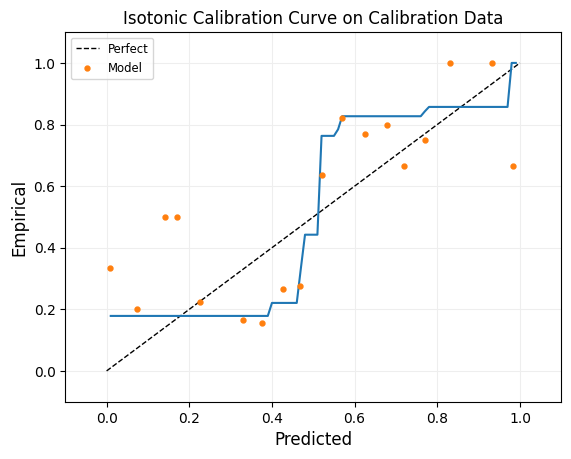

In [41]:
mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label="Isotonic")
plt.title("Isotonic Calibration Curve on Calibration Data")
plt.show();

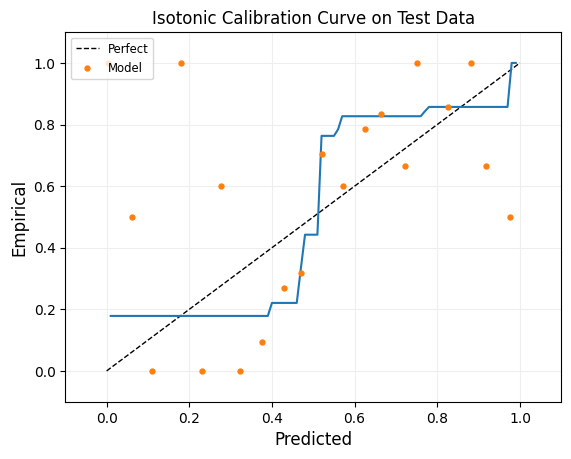

In [42]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label="Isotonic")
plt.title("Isotonic Calibration Curve on Test Data")
plt.show();

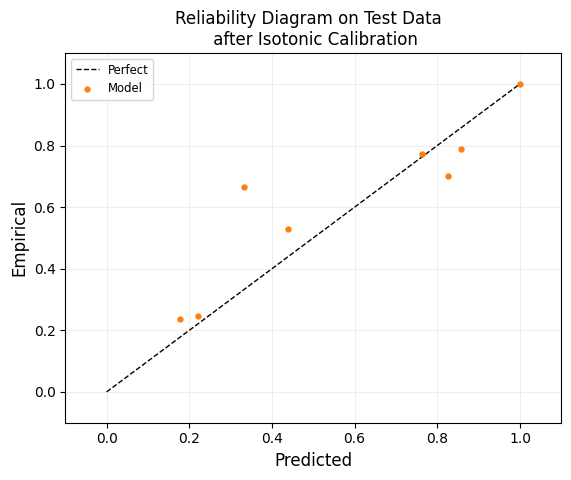

In [43]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba_iso, error_bars=False)
plt.title("Reliability Diagram on Test Data  \n after Isotonic Calibration")
plt.show();

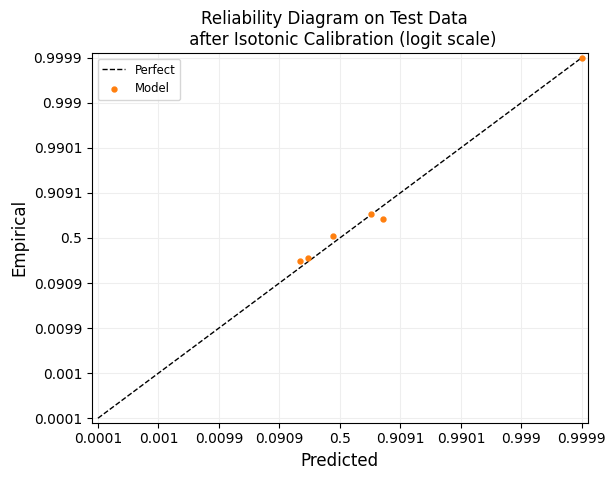

In [45]:
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])
rd = mli.plot_reliability_diagram(
    y_test, y_test_pred_proba_iso, scaling='logit', bins=custom_bins, error_bars=False
);

plt.title("Reliability Diagram on Test Data  \n after Isotonic Calibration (logit scale)")
plt.show();

### Platt sigmoid regression (Platt scaling)

A premise is made about the existence of a mapping from logistic functions between scores $z$ and true probabilities $p$.
$$\log\left( \dfrac{p}{1 - p} \right) = \alpha + \beta f_i$$

Then we have an optimization problem:
$$ p(y_i = 1| f_i) = \dfrac{1}{\exp(-(\alpha + \beta f_i))}$$

where $\alpha$ and $\beta$ parameters defines by maximum likelihood estimation, the same as in logistic regression.

The method has imposes restrictions on class of initial models - it was designed for SVM and its good working for others isn't guaranteed. But as an advantage we have robustness on small datasets.

In [46]:
lr = LogisticRegression(C=1e5, solver='lbfgs')
lr.fit(y_calib_pred_proba.reshape(-1, 1), y_calib)

LogisticRegression(C=100000.0)

In [47]:
y_calib_pred_proba_platt = lr.predict_proba(y_calib_pred_proba.reshape(-1, 1))[:, 1]
y_test_pred_proba_platt = lr.predict_proba(y_test_pred_proba.reshape(-1, 1))[:, 1]

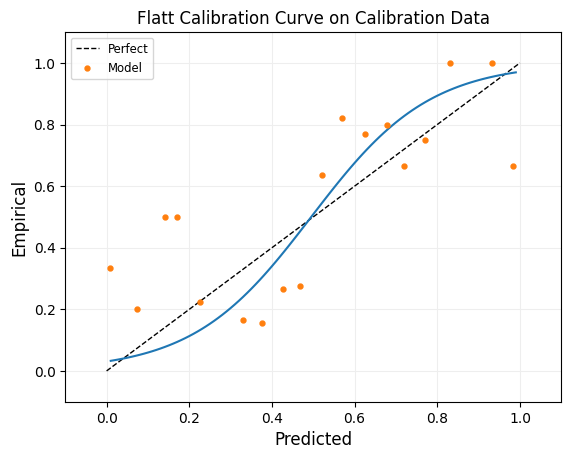

In [48]:
mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1, 1))[:, 1])
plt.title("Flatt Calibration Curve on Calibration Data")
plt.show();

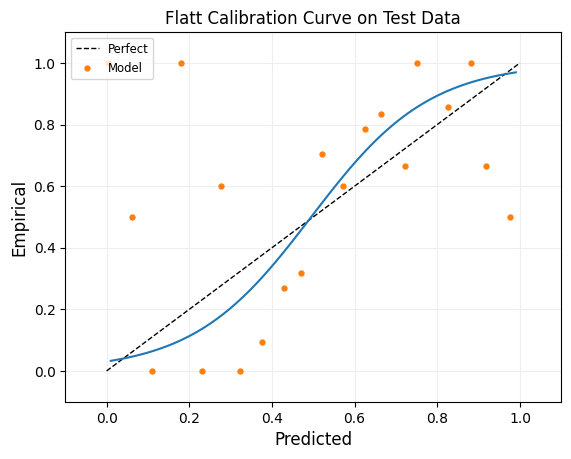

In [49]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1, 1))[:, 1])
plt.title("Flatt Calibration Curve on Test Data")
plt.show();

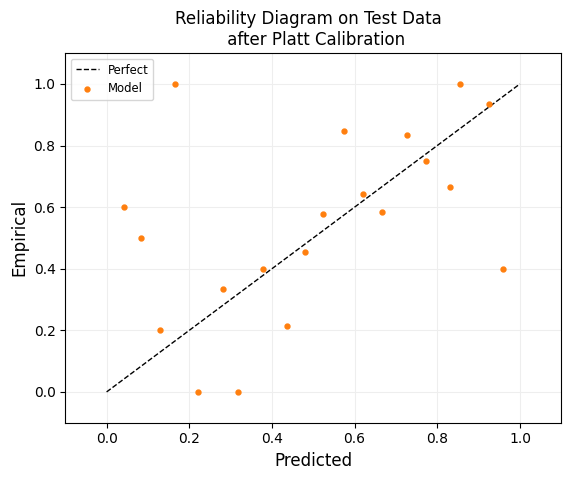

In [50]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba_platt, error_bars=False)
plt.title("Reliability Diagram on Test Data  \n after Platt Calibration")
plt.show();

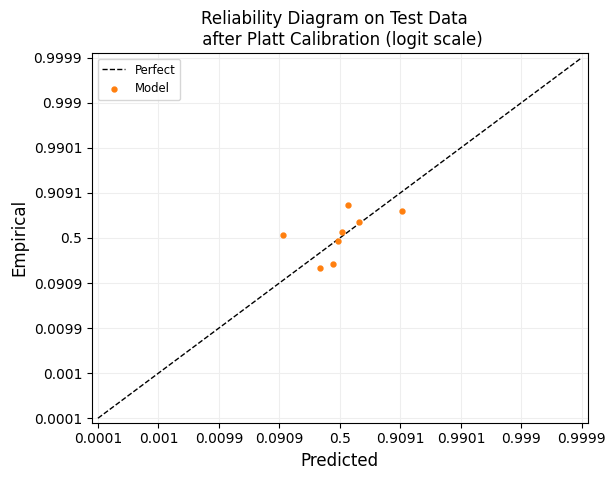

In [51]:
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])
rd = mli.plot_reliability_diagram(
    y_test, y_test_pred_proba_platt, scaling='logit', bins=custom_bins, error_bars=False
);

plt.title("Reliability Diagram on Test Data  \n after Platt Calibration (logit scale)")
plt.show();

With logit scale you can see the calibration does its job not so good in case of extramally small or large values. Generally speaking, it isn't surprising because errors like "too near to 0.5" are more preferable in point of log loss (better "underpredict" very likely event and "overpredict" rare event).

Despite of it we achieved some improvements in terms of log loss compared to isotonic regression.

In [52]:
print('Platt calibration log_loss = {}'.format(log_loss(y_test, y_test_pred_proba_platt)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test, y_test_pred_proba)))

Platt calibration log_loss = 0.6529478948241713
Uncalibrated log_loss = 0.6728050956632885


### Beta Calibration

"A well-founded and easily implemented on logistic calibration for binary classifiers"

$$p = \left( 1 + \left( e^C \dfrac{z^{\alpha}}{(1 - z)^{\beta}} \right)^{-1} \right)^{-1} $$

In general, beta calibration can be considered as improved version of Platt calibration:
* We have three-parameter family (in difference to Platt's two-parameter)
* Given functions familly includes identical mapping $y = x$, thus calibration with using this method at least not worse a situation for already well-calibrated models (we can't speak the same about previous methods).

In [54]:
!pip install betacal

In [55]:
from betacal import BetaCalibration

In [56]:
bc = BetaCalibration()
bc.fit(y_calib_pred_proba, y_calib)

BetaCalibration()

In [57]:
y_calib_pred_proba_bc = bc.predict(y_calib_pred_proba)
y_test_pred_proba_bc = bc.predict(y_test_pred_proba)

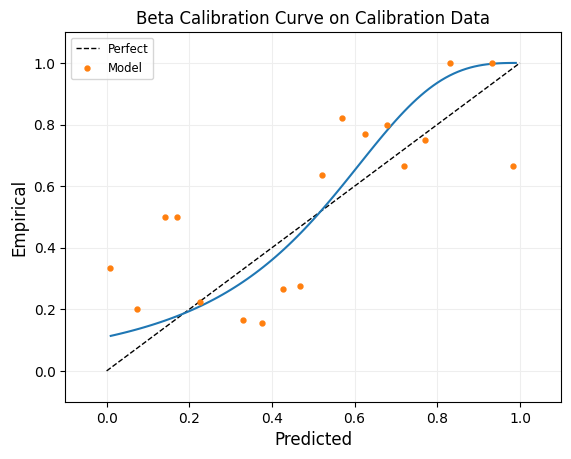

In [58]:
mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title("Beta Calibration Curve on Calibration Data")
plt.show();

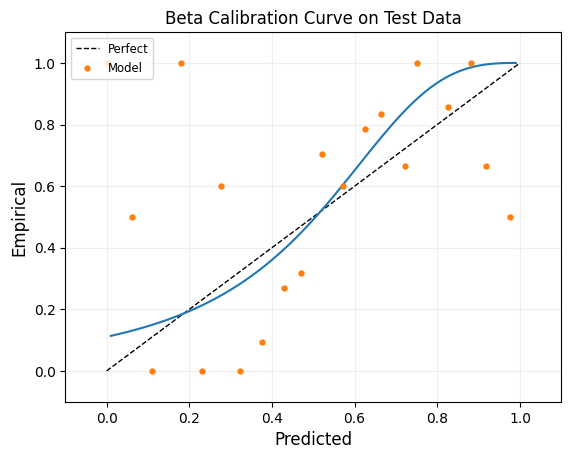

In [59]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title("Beta Calibration Curve on Test Data")
plt.show();

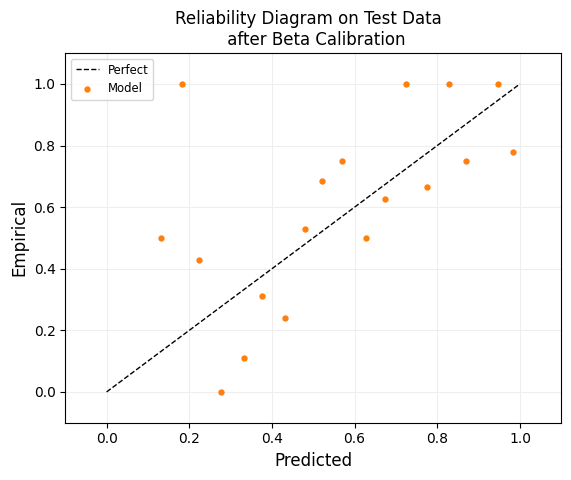

In [60]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba_bc, error_bars=False)
plt.title("Reliability Diagram on Test Data  \n after Beta Calibration")
plt.show();

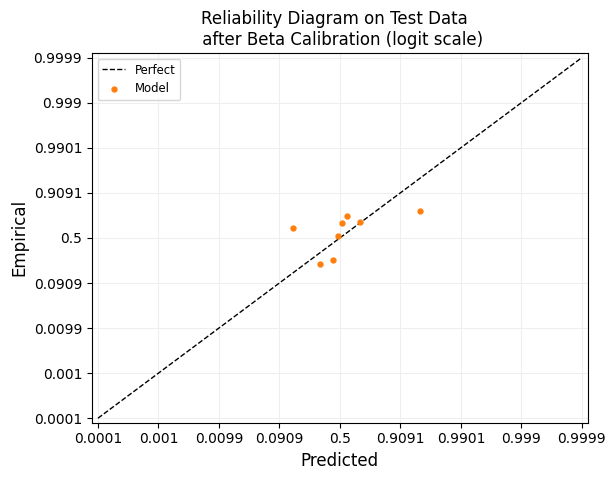

In [61]:
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])
rd = mli.plot_reliability_diagram(
    y_test, y_test_pred_proba_bc, scaling='logit', bins=custom_bins, error_bars=False
);

plt.title("Reliability Diagram on Test Data  \n after Beta Calibration (logit scale)")
plt.show();

Log loss for all the calibration methods (the larger it is the better):

In [63]:
print('Beta calibration log_loss = {}'.format(log_loss(y_test, y_test_pred_proba_bc)))
print('Isotonic calibration log_loss = {}'.format(log_loss(y_test, y_test_pred_proba_iso)))
print('Platt calibration log_loss = {}'.format(log_loss(y_test, y_test_pred_proba_platt)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test, y_test_pred_proba)))

Beta calibration log_loss = 0.6742594309637803
Isotonic calibration log_loss = 0.597361059392513
Platt calibration log_loss = 0.6529478948241713
Uncalibrated log_loss = 0.6728050956632885


### Calibration with cross-validation (sklearn)

In [65]:
from sklearn.calibration import CalibratedClassifierCV

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=11
)

base_estimator = svm_poly

calibrated_svm = CalibratedClassifierCV(
    base_estimator=base_estimator, method="isotonic"
)
calibrated_svm.fit(X_train, y_train)
print("Isotonic: ")
print(classification_report(y_test,calibrated_svm.predict(X_test)))

calibrated_platt_svm = CalibratedClassifierCV(
    base_estimator=base_estimator, method="sigmoid"
)
calibrated_platt_svm.fit(X_train, y_train)
print("Platt: ")
print(classification_report(y_test,calibrated_platt_svm.predict(X_test)))

Isotonic: 
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       131
           1       0.79      0.77      0.78       149

    accuracy                           0.77       280
   macro avg       0.77      0.77      0.77       280
weighted avg       0.77      0.77      0.77       280

Platt: 
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       131
           1       0.83      0.71      0.77       149

    accuracy                           0.77       280
   macro avg       0.78      0.78      0.77       280
weighted avg       0.78      0.77      0.77       280



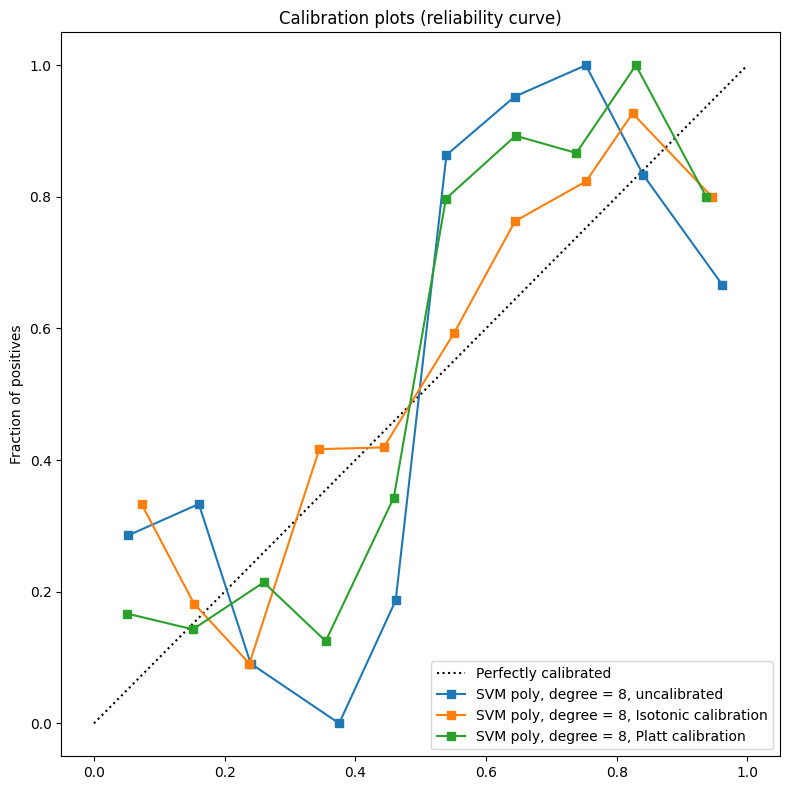

In [68]:
plt.figure(figsize=(8, 8))

plt.plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated")

prob_pos = svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)

plt.plot(
    mean_predicted_value,
    fraction_of_positives,
    "s-",
    label="SVM poly, degree = 8, uncalibrated"
)

prob_pos = calibrated_svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)

plt.plot(
    mean_predicted_value,
    fraction_of_positives,
    "s-",
    label="SVM poly, degree = 8, Isotonic calibration",
)

prob_pos = calibrated_platt_svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)

plt.plot(
    mean_predicted_value,
    fraction_of_positives,
    "s-",
    label="SVM poly, degree = 8, Platt calibration",
)

plt.ylabel("Fraction of positives")
plt.ylim(-0.05, 1.05)
plt.legend(loc="lower right")
plt.title("Calibration plots (reliability curve)")
plt.tight_layout()
plt.show();

As you can see, Platt calibration looks the best, because that curve the nearest to Perfectly calibrated line.